In [2]:
import json
f = open('datasets.json')
 
# returns JSON object as
# a dictionary
datasets = json.load(f)

In [3]:
import numpy as np
from PIL import Image
from math import ceil
from skimage.transform import rotate
def GetTransform(center, scale, rot, res, size):
    # Generate transformation matrix
    h = size * scale # size_src = size_dst * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res) / h
    t[1, 1] = float(res) / h
    t[0, 2] = res * (-float(center[0]) / h + .5)
    t[1, 2] = res * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res/2
        t_mat[1,2] = -res/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t

def TransformSinglePts(pts, center, scale, rot, res, size, invert=0):
    t = GetTransform(center, scale, rot, res, size)
    if invert:
        t = np.linalg.inv(t)
    new_pt = np.array([pts[0], pts[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)

def crop(img, center, scale, rot, res, size):
    # ndim = img.ndim
    # if ndim == 2:
    #     img = np.expand_dims(img, axis=2)
    scale_factor = float(scale * size) / float(res)
    # height, width = img.shape[0], img.shape[1]
    if scale_factor < 2:
        scale_factor = 1
    else:
        new_img_size = np.floor(max(img.shape[0], img.shape[1]) / scale_factor)
        if new_img_size < 2:
            return img
        else:
            img = Image.fromarray(img.astype('uint8'), 'RGB')
            img = img.resize((ceil(img.size[0]*(1/scale_factor)),ceil(img.size[1]*(1/scale_factor))), Image.BILINEAR)
            img = np.array(img)
            # height, width = tmp_img.shape[0], tmp_img.shape[1]
    center = center / scale_factor
    scale = scale / scale_factor

    # Upper left point
    ul = np.array(TransformSinglePts([0,0], center, scale, 0, res, size, invert=1))
    # Bottom right point
    br = np.array(TransformSinglePts([res,res], center, scale, 0, res, size, invert=1))

    # make sure br - ul = (res, res)
    if scale_factor >= 2:
        br = br - (br - ul - res)

    # Padding so that when rotated proper amount of context is included
    pad = np.ceil(np.linalg.norm(br - ul) / 2 - float(br[1] - ul[1]) / 2).astype(int)
    if not rot == 0:
        ul -= pad
        br += pad

    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if img.ndim > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape)

    # Range to fill new array
    ht = img.shape[0]
    wd = img.shape[1]
    new_x = max(0, -ul[0]), min(br[0], wd) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], ht) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(wd, br[0])
    old_y = max(0, ul[1]), min(ht, br[1])

    new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], old_x[0]:old_x[1]]

    if not rot == 0:
        # Remove padding
        # print new_img.shape
        new_img = rotate(new_img, rot)
        new_img = new_img[pad:-pad, pad:-pad]

    new_img = Image.fromarray(new_img.astype('uint8'), 'RGB')
    # new_img = scipy.misc.toimage(new_img.astype('uint8'))
    # new_img.save('tmp.jpg')
    #return imresize(new_img, (res, res))
    return np.array(new_img.resize((res,res), Image.BILINEAR))
# === End of Img.py === #

4.734087451663731
dict_keys(['x1', 'y1', 'x2', 'y2', 'keypoints', 'scale', 'objpos'])
[966, 340]


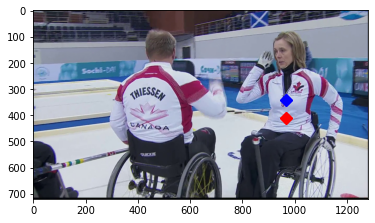

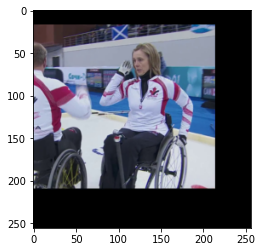

(720, 1280, 3)


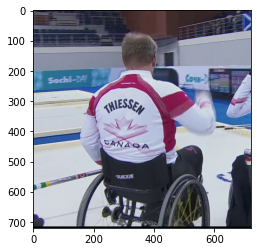

In [18]:

import matplotlib.pyplot as plt
import imageio
import numpy as np
import imgaug.augmenters as iaa


def sample_from_bounded_gaussian(x):
    return max(-2*x, min(2*x, np.random.randn()*x))

img1path = f"../images_mpii/{datasets['dataset']['MPII']['filepath'][2]}" 
a = datasets['dataset']['MPII']['people'][2]
print(a["info"][1]["scale"])
print(a["info"][1].keys())
x1 = a["info"][1]["x1"]
x2 = a["info"][1]["x2"]
y1 = a["info"][1]["y1"]
y2 = a["info"][1]["y2"]
c = [a["info"][0]["objpos"]["x"],a["info"][0]["objpos"]["y"]]
print(c)
s = a["info"][1]["scale"]
c2 = c.copy()
c2[1] = c2[1] + 15*s
s = s * 1.25
s = s * ( 2**(sample_from_bounded_gaussian(0.25)))
img = imageio.imread(img1path)
plt.imshow(img)
plt.scatter(c[0],c[1],marker="x",c="b",linewidths=10)
plt.scatter(c2[0],c2[1],marker="x",c="r",linewidths=10)
plt.show()
inp = crop(img,np.array(c2),np.array(s),0,256,128)
plt.imshow(inp)
plt.show()

def normalize_coordinates(row_i, col_j, img):
    num_rows, num_cols = img.shape[:2]
    x = col_j/(num_cols - 1.)
    y = row_i/(num_rows - 1.)
    return (x, y)

aug = iaa.Sequential([
    iaa.CropToSquare(position=normalize_coordinates(c2[1],c2[0],img)),
    iaa.Affine(
        scale={"x": (0.4, 1.25), "y": (0.4, 1.25)},
    )
])

#aug = iaa.CropToSquare(position=normalize_coordinates(c2[1],c2[0],img))

print(img.shape)
img2 = aug(images=np.reshape(img,((1,)+img.shape)))
plt.imshow(np.squeeze(img2))
plt.show()

In [2]:
print(datasets["dataset"]["LSP"]["keypoints"][1]["points"])

[{'x': 28.120318970834436, 'y': 166.65510177108112, 'id': 1}, {'x': 49.17944312274209, 'y': 136.64584985461272, 'id': 2}, {'x': 62.604634769583235, 'y': 95.84379681029161, 'id': 3}, {'x': 80.2416512468059, 'y': 96.10703586219046, 'id': 4}, {'x': 91.56093047845627, 'y': 130.8545907128381, 'id': 5}, {'x': 78.39897788351396, 'y': 142.70034804828614, 'id': 6}, {'x': 61.288439510089006, 'y': 78.99649748876548, 'id': 7}, {'x': 49.96916027843864, 'y': 73.73171645078857, 'id': 8}, {'x': 63.92083002907746, 'y': 50.56667988369015, 'id': 9}, {'x': 98.66838487972508, 'y': 53.46230945457745, 'id': 10}, {'x': 111.3038593708697, 'y': 69.78313067230589, 'id': 11}, {'x': 109.46118600757778, 'y': 96.37027491408931, 'id': 12}, {'x': 81.03136840250245, 'y': 52.6725922988809, 'id': 13}, {'x': 83.40051986959206, 'y': 30.823750991276704, 'id': 14}]


{'normalizer': 125.877, 'isValidation': 0.0, 'joint_others': [[[895.0, 293.0, 1.0], [910.0, 279.0, 1.0], [945.0, 223.0, 0.0], [1012.0, 218.0, 1.0], [961.0, 315.0, 1.0], [960.0, 403.0, 1.0], [979.0, 221.0, 0.0], [906.0, 190.0, 0.0], [912.491, 190.659, 1.0], [830.509, 182.341, 1.0], [871.0, 304.0, 1.0], [883.0, 229.0, 1.0], [888.0, 174.0, 0.0], [924.0, 206.0, 1.0], [1013.0, 203.0, 1.0], [955.0, 263.0, 1.0]]], 'people_index': 1.0, 'scale_provided': 3.021, 'joint_self': [[620.0, 394.0, 1.0], [616.0, 269.0, 1.0], [573.0, 185.0, 1.0], [647.0, 188.0, 0.0], [661.0, 221.0, 1.0], [656.0, 231.0, 1.0], [610.0, 187.0, 0.0], [647.0, 176.0, 1.0], [637.02, 189.818, 1.0], [695.98, 108.182, 1.0], [606.0, 217.0, 1.0], [553.0, 161.0, 1.0], [601.0, 167.0, 1.0], [692.0, 185.0, 1.0], [693.0, 240.0, 1.0], [688.0, 313.0, 1.0]], 'objpos_other': [[952.0, 222.0]], 'img_width': 1280.0, 'dataset': 'MPII', 'img_height': 720.0, 'objpos': [594.0, 257.0], 'scale_provided_other': 2.472, 'annolist_index': 5.0, 'img_paths

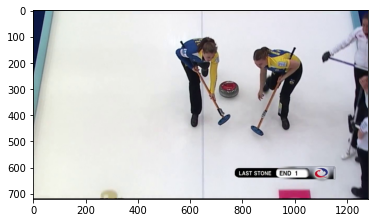

In [75]:
import matplotlib.pyplot as plt
import imageio
print(cacca[0])
print(cacca[1])
plt.imshow(imageio.imread("../images_mpii/015601864.jpg"))
plt.show()

In [ ]:
#np.savez_compressed(folder_imgs + '/patches_imgs', np.array(imgs))
#np.load(f"../sartorius/test/imgs/{cellClass}/patches_imgs.npz")['arr_0']

../images_lsp/im0001.jpg
(160, 70, 3)
(1, 14, 2)
(1, 14, 2)
(128, 128, 3)
[ 29.74645941 143.34544031]
[ 54.39352798 114.67635345]


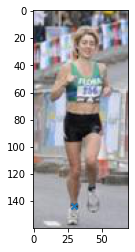

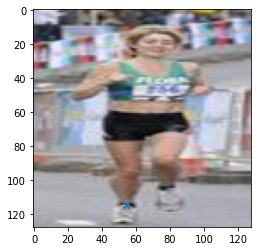

In [66]:
import imageio
import glob
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables import Keypoint, KeypointsOnImage
import matplotlib.pyplot as plt

"""seq = iaa.Sequential([
    iaa.Affine(
        scale=(0.75, 1.25)
    ) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
    ,
    iaa.Affine(rotate=30),
    iaa.Affine(rotate=330),
    iaa.Fliplr(0.5)
])"""
seq = iaa.Sequential([
    iaa.Resize({"height": 128, "width": 128})
])

lspDataset = datasets["dataset"]["LSP"]
paths = sorted(glob.glob("../images_lsp/*.jpg"))
print(paths[0])
for i in range(1):
    img = imageio.imread(paths[i])
    print(img.shape)
    keypoints = []
    for j in range(14):
        p = lspDataset["keypoints"][i]["points"][j]
        coords = []
        coords.append(p["x"])
        coords.append(p["y"])
        coords = np.array(coords)
        keypoints.append(coords)
    keypoints = np.array(keypoints)
    keypoints = np.reshape(keypoints,(1,)+keypoints.shape)
    print(keypoints.shape)

    img2, kp2 = seq(image=img,keypoints=keypoints)
    print(kp2.shape)
    
    print(img2.shape)
print(keypoints[0][0])
print(kp2[0][0])
plt.imshow(img)
plt.scatter(keypoints[0][0][0],keypoints[0][0][1],marker="x",linewidths=2)
plt.show()
plt.imshow(img2)
plt.scatter(kp2[0][0][0],kp2[0][0][1],marker="x",linewidths=2)
plt.show()


In [25]:
#Creazione file npy LSP
import imageio
import glob
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables import Keypoint, KeypointsOnImage

lspDataset = datasets["dataset"]["LSP"]
paths = sorted(glob.glob("../images_lsp/*.jpg"))
for i in range(len(paths)):
    img = imageio.imread(paths[i])
    keypoints = []
    for i in range(14):
        p = lspDataset["keypoints"][i]["points"]
        coords = []
        coords.append(p["x"])
        coords.append(p["y"])
        keypoints.append(coords)
    seq = iaa.Sequential([
        iaa.Affine(
            scale=(0.75, 1.25)
        ) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
        ,
        iaa.Sometimes(0.5,iaa.Affine(rotate=30),)
    ])
        
    
    

TypeError: list indices must be integers or slices, not str